# Modelling Extreme values for the Wind Farm project

This notebook is a brief example of the possibilities offered by the toolbox for modeling extreme values, adapted from the tools provided from the ResourceCode website.

It relies on the `pyextreme` library which get installed with the Resourcecode toolbox. Here we demonstrate 2 examples of univariate modeling as shown in class. For more information, see https://georgebv.github.io/pyextremes/.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from pyextremes import (
    plot_mean_residual_life,
    plot_parameter_stability, 
    EVA
)
import resourcecode

from resourcecode.eva import (
    censgaussfit,
    get_fitted_models,
    get_gpd_parameters,
    run_simulation,
    huseby,
)
import warnings
warnings.filterwarnings("ignore")

We first load the data from the example Dieppe-Le Tréport location `169325` (coordinates: $(1.084, 50.138)$).

AttributeError: 'DataFrame' object has no attribute 'get_closest_point'

In [22]:
client = resourcecode.Client()
data = client.get_dataframe_from_criteria(
    """
{
    "node": 169325,
    "start": 0,
    "end": 99999903600,
    "parameter": ["hs","uwnd","vwnd"]
}
"""
)

# 1) find nearest mesh point to your coords
lat, lon = 47.5882, -3.3215  # <-- your coordinates (decimal degrees)
point_id, distance_m = client.get_closest_point(latitude=lat, longitude=lon)

print(point_id, distance_m, "m from requested coords")

AttributeError: 'Client' object has no attribute 'get_closest_point'

In [3]:
data.head()

,hs,uwnd,vwnd
1994-01-01 00:00:00,1.858,5.9,-1.7
1994-01-01 01:00:00,1.770,6.0,-1.6
1994-01-01 02:00:00,1.626,6.2,-1.7
1994-01-01 03:00:00,1.486,6.6,-2.4
1994-01-01 04:00:00,1.382,6.1,-2.9


From the $u$ and $v$ components of the wind, calculate the wind speed and direction.

In [4]:
data["wspd"], data["wdir"] = resourcecode.utils.zmcomp2metconv(data.uwnd, data.vwnd)

In [5]:
data.head()

,hs,uwnd,vwnd,wspd,wdir
1994-01-01 00:00:00,1.858,5.9,-1.7,6.140033,286.073574
1994-01-01 01:00:00,1.770,6.0,-1.6,6.209670,284.931417
1994-01-01 02:00:00,1.626,6.2,-1.7,6.428841,285.333285
1994-01-01 03:00:00,1.486,6.6,-2.4,7.022820,289.983107
1994-01-01 04:00:00,1.382,6.1,-2.9,6.754258,295.426874


### Modelling univariate time series: Block maxima + GEVD (Generalized Extreme Value Distribution)

We show as an example here a **BM** (block maxima) model fitted to the $H_s$ time series. In this approach, the maximum value is identified within a "block" or fixed period in time, and then a GEVP distribution is fit to the data to estimate the return values.  

The same plot can readily be obtained for the other sea-state parameters.

After loading the data, apply the block method approach with a block size of 1 year (365.2425 days), where each data block must be at least 90% full to take into account in the analysis.

In [6]:
model = EVA(data.hs)
model.get_extremes(method="BM", block_size="365.2425D", min_last_block=0.9)

In [7]:
model.extremes.head()

date-time
1994-01-26 05:00:00    4.444
1995-03-17 17:00:00    4.056
1996-10-29 02:00:00    4.784
1997-02-13 12:00:00    4.668
1998-10-25 02:00:00    4.890
Name: hs, dtype: float64

(<Figure size 768x480 with 1 Axes>, <Axes: xlabel='date-time', ylabel='hs'>)

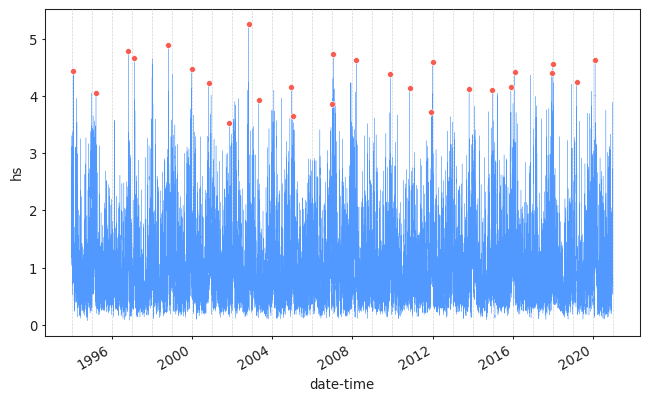

In [8]:
model.plot_extremes()

In [9]:
model.fit_model()

The parameter alpha specifies the confidence limits (default = 0.95).

In [10]:
model.plot_diagnostic(alpha=0.95)

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='hs'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='hs', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

The parameter n_samples indicates the number of bootstrap samples used to estimate the confidence bounds.

In [11]:
summary = model.get_summary(
        return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
        alpha=0.95,
        n_samples=1000,
    )
print(summary)

               return value  lower ci  upper ci
return period                                  
1.0                    -inf       NaN       NaN
2.0                4.319581  4.170073  4.503104
5.0                4.667826  4.487042  4.828539
10.0               4.848191  4.609878  5.022067
25.0               5.031322  4.696032  5.246619
50.0               5.140935  4.727979  5.409785
100.0              5.231704  4.746003  5.579138
250.0              5.328760  4.761671  5.798726
500.0              5.388186  4.771888  5.948580
1000.0             5.437817  4.779016  6.120480


### Modelling univariate time series: Peaks over threshold (POT) + GPD (Generalized Pareto Distribution)

We show as example here a **POT** (peaks over threshold) model fitted to the $H_s$ time series. This analysis first finds values over a specified threshold and then declusters these values using a predefined clustering distance, and finally finds the maximum value within each cluster. 

The same plot can readily be obtained for the other sea-state parameters.

We first can have a look at the quality of the fitted model, and to the corresponding return levels as a function of the selected wave height threshold. The parameters r and alpha specify the minimum time distance (duration) between adjacent clusters and the confidence limits (default = 0.95), respectively.

The shape and modified scale parameters define the Generalized Pareto Distribution, and they depend on the threshold value, but should be stable within a range of valid thresholds (e.g. less than ~3m here).

In [12]:
plot_parameter_stability(ts=data.hs,r='72H',alpha=.95);

/opt/anaconda3/lib/python3.12/site-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  r = pd.to_timedelta(r)
/opt/anaconda3/lib/python3.12/site-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  r = pd.to_timedelta(r)
/opt/anaconda3/lib/python3.12/site-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  r = pd.to_timedelta(r)
/opt/anaconda3/lib/python3.12/site-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  r = pd.to_timedelta(r)
/opt/anaconda3/lib/python3.12/site-packages/pyextremes/extremes/peaks_over_threshold.py:18: FutureWarning: 'H' i

The mean residual life plots the average excess value over a given threshold, and it should be approcimately linear above the threshold for which the GPD model is valid (e.g. <~3m)

In [13]:
plot_mean_residual_life(data.hs);

The analysis is completed for both Hs and the wind speed, specifying a window of 72 hours and a quantile of 0.98 for determining the threshold to specify.

In [14]:
quant=0.98
models = get_fitted_models(data[["hs","wspd"]],quantile=quant,r="72H")

In [15]:
models

[                           Univariate Extreme Value Analysis                            
                                       Source Data                                       
 ----------------------------------------------------------------------------------------
 Data label:                            hs      Size:                             236,688
 Start:                       January 1994      End:                        December 2020
                                      Extreme Values                                     
 ----------------------------------------------------------------------------------------
 Count:                                260      Extraction method:                    POT
 Type:                                high      Threshold:                          2.854
                                          Model                                          
 ----------------------------------------------------------------------------------------
 Model:   

In [16]:
models[0].plot_diagnostic(alpha=0.95);

In [17]:
models[1].plot_diagnostic(alpha=0.95);

In [18]:
pd.DataFrame(get_gpd_parameters(models),columns=["mu","sigma","xi"],index=["Hs","Wspd"])

,mu,sigma,xi
Hs,2.85400,0.729338,-0.248138
Wspd,13.04982,2.343327,-0.259548


In [19]:
summary_Hs = models[0].get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100],
    alpha=0.95,
    n_samples=1000,
)
summary_Wspd = models[1].get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100],
    alpha=0.95,
    n_samples=1000,
)
print(summary_Hs)
print(summary_Wspd)

               return value  lower ci  upper ci
return period                                  
1.0                4.117648  4.001450  4.223840
2.0                4.382422  4.237926  4.504572
5.0                4.669342  4.472665  4.824074
10.0               4.846939  4.601008  5.033554
25.0               5.039390  4.720786  5.292180
50.0               5.158512  4.787669  5.472380
100.0              5.258811  4.831295  5.635192
               return value   lower ci   upper ci
return period                                    
1.0               17.367331  17.032784  17.671841
2.0               18.142996  17.732336  18.478997
5.0               18.975930  18.445322  19.408743
10.0              19.486738  18.822464  20.013939
25.0              20.035261  19.181950  20.668836
50.0              20.371649  19.378613  21.115521
100.0             20.652651  19.526319  21.531552
